# Depthwise Separable Model

This notebook tries to decide which architecture is the most suitable for a depthwise separable layer on FPGA.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Design Models

In [73]:
class DesignModel(object):
    def __init__(self, tile_height, tile_width, tile_in_depth, tile_out_depth, kernel_size):
        self.T_H = tile_height
        self.T_W = tile_width
        self.T_ID = tile_in_depth
        self.T_OD = tile_out_depth
        self.K = kernel_size
        self.T_IH = self.T_H - self.K + 1
        self.T_IW = self.T_W - self.K + 1

class PipelineDesignModel(DesignModel):
    def __init__(self, T_H, T_W, T_ID, T_OD, K):
        super().__init__(T_H, T_W, T_ID, T_OD, K)
        
    def num_cycles(self, P_W, P_ID, P_OD):
        return (self.T_ID /P_ID * 
                (self.T_IH * self.T_IW / P_W +
                 self.T_IH * self.T_IW / P_W * (self.T_OD / P_OD - 1)))
    
    def num_mults(self, P_W, P_ID, P_OD):
        return (P_ID * P_W * K * K +
                P_ID * P_OD)

class TimeMuxDesignModel(DesignModel):
    def num_cycles(self, P_W0, P_ID0, P_W1, P_ID1, P_OD):
        return ((self.T_ID / P_ID0 * self.T_IH * self.T_IW / P_W0) +
                (self.T_ID / P_ID1 * self.T_H * self.T_W / P_W1 * self.T_OD / P_OD))
    
    def num_mults(self, P_W0, P_ID0, P_W1, P_ID1, P_OD):
        return max(P_W0 * P_ID0 * self.K * self.K,
                   P_ID1 * P_W1 * P_OD)

In [74]:
# constants
T_H = 32
T_W = 32
T_ID = 32
T_OD = 32
K = 3

In [75]:
ppl = PipelineDesignModel(T_H, T_W, T_ID, T_OD, K)
tmx = TimeMuxDesignModel(T_H, T_W, T_ID, T_OD, K)

## Explore Multipliers / Performance

This evaluation result shows that a pipelined design is a better choice, comparing with the time-multiplexed version.

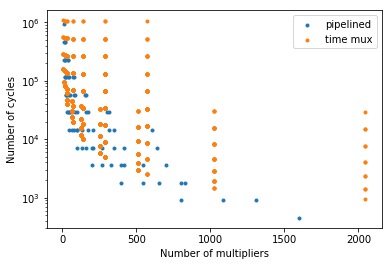

In [78]:
def factors(n):
    return [i for i in range(1, n+1) if n % i == 0]

P_Ws = [1, 2]
P_IDs = factors(T_ID)
P_ODs = factors(T_OD)
ppl_cands = list(itertools.product(P_Ws, P_IDs, P_ODs))
tmx_cands = list(itertools.product(P_Ws, P_IDs, P_Ws, P_IDs, P_ODs))

ppl_xs = [ppl.num_mults(P_W, P_ID, P_OD) for P_W, P_ID, P_OD in ppl_cands]
ppl_ys = [ppl.num_cycles(P_W, P_ID, P_OD) for P_W, P_ID, P_OD in ppl_cands]
tmx_xs = [tmx.num_mults(P_W0, P_ID0, P_W1, P_ID1, P_OD)
          for P_W0, P_ID0, P_W1, P_ID1, P_OD in tmx_cands]
tmx_ys = [tmx.num_cycles(P_W0, P_ID0, P_W1, P_ID1, P_OD)
          for P_W0, P_ID0, P_W1, P_ID1, P_OD in tmx_cands]

plt.scatter(ppl_xs, ppl_ys, marker='.', label='pipelined')
plt.scatter(tmx_xs, tmx_ys, marker='.', label='time mux')

plt.xlabel('Number of multipliers')
plt.ylabel('Number of cycles')
plt.yscale('log')
plt.legend()